# 
Transformer
:label:`sec_transformer`

 :numref:`subsec_cnn-rnn-self-attention`中比较了卷积神经网络（CNN）、循环神经网络（RNN）和自注意力（self-attention）。值得注意的是，自注意力同时具有并行计算和最短的最大路径长度这两个优势。因此，使用自注意力来设计深度架构是很有吸引力的。对比之前仍然依赖循环神经网络实现输入表示的自注意力模型 :cite:`Cheng.Dong.Lapata.2016,Lin.Feng.Santos.ea.2017,Paulus.Xiong.Socher.2017`，Transformer模型完全基于注意力机制，没有任何卷积层或循环神经网络层 :cite:`Vaswani.Shazeer.Parmar.ea.2017`。尽管Transformer最初是应用于在文本数据上的序列到序列学习，但现在已经推广到各种现代的深度学习中，例如语言、视觉、语音和强化学习领域。

## 模型

Transformer作为编码器－解码器架构的一个实例，其整体架构图在 :numref:`fig_transformer`中展示。正如所见到的，Transformer是由编码器和解码器组成的。与 :numref:`fig_s2s_attention_details`中基于Bahdanau注意力实现的序列到序列的学习相比，Transformer的编码器和解码器是基于自注意力的模块叠加而成的，源（输入）序列和目标（输出）序列的*嵌入*（embedding）表示将加上*位置编码*（positional encoding），再分别输入到编码器和解码器中。

![transformer架构](../img/transformer.svg)
:width:`500px`
:label:`fig_transformer`

图 :numref:`fig_transformer`中概述了Transformer的架构。从宏观角度来看，Transformer的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为$\mathrm{sublayer}$）。第一个子层是*多头自注意力*（multi-head self-attention）汇聚；第二个子层是*基于位置的前馈网络*（positionwise feed-forward network）。具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。受 :numref:`sec_resnet`中残差网络的启发，每个子层都采用了*残差连接*（residual connection）。在Transformer中，对于序列中任何位置的任何输入$\mathbf{x} \in \mathbb{R}^d$，都要求满足$\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便残差连接满足$\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$。在残差连接的加法计算之后，紧接着应用*层规范化*（layer normalization） :cite:`Ba.Kiros.Hinton.2016`。因此，输入序列对应的每个位置，Transformer编码器都将输出一个$d$维表示向量。

Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为*编码器－解码器注意力*（encoder-decoder attention）层。在编码器－解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种*掩蔽*（masked）注意力保留了*自回归*（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。

在此之前已经描述并实现了基于缩放点积多头注意力 :numref:`sec_multihead-attention`和位置编码 :numref:`subsec_positional-encoding`。接下来将实现Transformer模型的剩余部分。


In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## [**基于位置的前馈网络**]

基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是*基于位置的*（positionwise）的原因。在下面的实现中，输入`X`的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，`ffn_num_outputs`）的输出张量。


In [2]:
# 对序列中每一个位置的向量，都通过 相同的两层感知机（MLP） 进行非线性变换。
# 每个位置单独处理，但用的是共享的网络参数

#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        # 每个位置上的向量：先线性变换 → 激活 → 再线性变换，输出新向量。
        return self.dense2(self.relu(self.dense1(X)))

下面的例子显示，[**改变张量的最里层维度的尺寸**]，会改变成基于位置的前馈网络的输出尺寸。因为用同一个多层感知机对所有位置上的输入进行变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。

解释：可以看到下面的输出，每一个向量指的是序列中每一个位置的词向量，也就是每一行，他们会被分别送入基于位置的前馈网路。从输出中可以看出，当我们的每一个向量一样时，通过基于位置的前馈神经网络的输出也是一样的。

复习激活函数的核心作用：[**为网络引入非线性，使模型能逼近复杂函数。**]

In [3]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.0631,  0.2193,  0.3359,  0.3049,  0.3653, -0.6286, -0.2246,  0.4325],
        [-0.0631,  0.2193,  0.3359,  0.3049,  0.3653, -0.6286, -0.2246,  0.4325],
        [-0.0631,  0.2193,  0.3359,  0.3049,  0.3653, -0.6286, -0.2246,  0.4325]],
       grad_fn=<SelectBackward0>)

## 残差连接和层规范化

现在让我们关注 :numref:`fig_transformer`中的*加法和规范化*（add&norm）组件。正如在本节开头所述，这是由残差连接和紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。

 :numref:`sec_batch_norm`中解释了在一个小批量的样本内基于批量规范化对数据进行重新中心化和重新缩放的调整。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

以下代码[**对比不同维度的层规范化和批量规范化的效果**]。


In [4]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

# LayerNorm：在每一行上做归一化（对单个样本的特征维度归一化）
# BatchNorm：在每一列上做归一化（对整个 batch 的每个特征做归一化）

# LayerNorm 保持了样本之间的相对差异
# BatchNorm 会受到 batch 分布影响，更适合 CNN，用于 NLP 效果不佳

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在可以[**使用残差连接和层规范化**]来实现`AddNorm`类。暂退法也被作为正则化方法使用。


In [5]:
#@save
# 这个模块做的是 LayerNorm(X+Dropout(Y))

# X 是残差分支（原始输入）
# 残差连接中的那个 X 就是子层的输入，子层输出是 Sublayer(X)，两者相加再归一化，最终送给下一层。

# Y 是子层输出（如 self-attention 或 FFN 的输出）
# 在编码器中，子层输出有两种，一种是源于多头自注意力的注意力输出，另一种是源于基于位置的前馈网络的FFN输出

class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)  # dropout(Y) 是防止过拟合
        self.ln = nn.LayerNorm(normalized_shape)  # 两者相加后，再做归一化处理（在每个词向量的维度上）

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

残差连接要求两个输入的形状相同，以便[**加法操作后输出张量的形状相同**]。


In [6]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 编码器

有了组成Transformer编码器的基础组件，现在可以先[**实现编码器中的一个层**]。下面的`EncoderBlock`类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。


In [7]:
# 一个block包含两个子层：多头注意力 + 基于位置的前馈网络

#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        # 1. 构造多头自注意力层：
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)

        # 2. 构造第一个 Add & Norm 模块（注意力后）
        self.addnorm1 = AddNorm(norm_shape, dropout)

        # 3. 构造前馈网络 FFN 和第二个 Add & Norm 模块：
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    # 向前传播部分
    # 这个过程非常关键，是 Transformer 编码器的标准结构：
    # 1、输入 X → 自注意力模块 → 加残差 AddNorm1：Y=LayerNorm(X+Dropout(Attention(X)))
    # 2、Y → 前馈网络 → 再加残差 AddNorm2：Z=LayerNorm(Y+Dropout(FFN(Y)))
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

正如从代码中所看到的，[**Transformer编码器中的任何层都不会改变其输入的形状**]。


In [8]:
# 两个batch，长为100的序列，每个单元为24维向量
X = torch.ones((2, 100, 24))  

# 真实长度，第一个batch为3，第二个batch为2
valid_lens = torch.tensor([3, 2])  

# 设置编码器的一个层（包含两个子层）
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()  # 评估模式
encoder_blk(X, valid_lens).shape # 查看X经过一个编码器的一个层后形状是否发生变化

# 从输出来看，X的形状没有发生变化

torch.Size([2, 100, 24])

下面实现的[**Transformer编码器**]的代码中，堆叠了`num_layers`个`EncoderBlock`类的实例。由于这里使用的是值范围在$-1$和$1$之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。


In [9]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)

         # 定义编码维度
        self.num_hiddens = num_hiddens
        # 定义隐藏层维度（即词向量的维度、注意力输出的维度等）

        # 词嵌入层 embedding
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 将词 ID（整数）映射为向量，例如词表大小是 10000，每个词嵌入成 512维向量。

        # 位置编码层 pos_encoding
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 使用位置编码为每个位置添加位置信息（因为 Transformer 没有时序结构，必须加位置编码）

        # 堆叠多层 EncoderBlock
        self.blks = nn.Sequential()  # nn.Sequential() 是一个顺序容器
        for i in range(num_layers):
            # 每次循环创建一个 EncoderBlock，一共堆叠 num_layers 层
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。

        # 对输入 X 做 embedding 并放大
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # self.embedding(X)：将词 index 转成向量
        # 乘以根号d：为防止位置编码对数值影响太大（来自论文）
        # 加上 pos_encoding：加上位置信息

        # 初始化 attention 权重存储容器
        self.attention_weights = [None] * len(self.blks)
        # 用来存储每层的注意力权重，方便后续可视化。

        # 逐层调用 EncoderBlock 处理 X
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        # 输入 X 会依次流过每一个 EncoderBlock
        # 每一层输出仍是形状不变的(b,n,h)
        # 注意力权重会存下来，用于分析可视化（如可解释性分析）

        # 最终返回的是经过多个 EncoderBlock 编码后的结果，每个 token 都被编码成了语义丰富的向量。
        return X

下面我们指定了超参数来[**创建一个两层的Transformer编码器**]。
Transformer编码器输出的形状是（批量大小，时间步数目，`num_hiddens`）。


In [10]:
# 构造 Transformer 编码器
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
# (vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape输入张量的形状 [序列长度，嵌入维度], ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)

# 进入评估模式，禁用dropout，用于测试和可视化
encoder.eval()

# 输入张量测试
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape
# 输入：形状是 (2, 100) 的整数张量，表示一个 batch 中有2个句子，每个句子有100个 token（词 ID）
# dtype=torch.long：符合词 ID 的整数类型
# valid_lens：是一个张量，用来指明每个句子有效长度（避免 attention 看 padding）
# encoder(...)：把这个输入喂进刚刚构造好的 Transformer 编码器中
# .shape：查看输出的形状

torch.Size([2, 100, 24])

## 解码器

如 :numref:`fig_transformer`所示，[**Transformer解码器也是由多个相同的层组成**]。在`DecoderBlock`类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。关于*序列到序列模型*（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数`dec_valid_lens`，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。


In [11]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i

        # 构造函数中主要包括以下三个子层：

        # ① 自注意力（decoder 的 self-attention）
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # attention1 是解码器对自己的输入做自注意力（只能看到之前生成的 token）
        # addnorm1 是残差连接 + LayerNorm

        # ② 编码器-解码器注意力（encoder-decoder attention）
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        # 这是解码器读 encoder 输出的部分，允许 decoder “看到” 源句子
        # addnorm2 是第二个残差连接

        # ③ 前馈网络（Positionwise FFN）
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        # 标准位置前馈网络
        # addnorm3 是第三个残差连接

    # 标准位置前馈网络
    # addnorm3 是第三个残差连接
    def forward(self, X, state):
        # 其中 X 是当前解码器的输入，state 是外部传入的上下文状态（包括 encoder 的输出、中间缓存等）

        # 第一步：处理解码器自注意力
        enc_outputs, enc_valid_lens = state[0], state[1]
        # state[0]：编码器的输出
        # state[1]：源句子的有效长度（用于屏蔽 padding）

        # 🔁 构建当前 decoder block 的 key-value 缓存（用于推理时累积历史信息）
        # state[2][i] 就是第 i 个 decoder block 的缓存
        if state[2][self.i] is None:
            key_values = X  
            # 如果是第一个输出（还没有缓存），直接使用当前输入作为 key-values
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)  
            # 如果是第二个开始的输出，缓存区里已经有了前面的时间步输入，那就讲缓存区拥有的前面时间步的输入和当前时间步的输入拼在一起进行输入
        state[2][self.i] = key_values  # 更新缓存区的缓存（加上当前时间步的输入到缓存区中）
        # 🚫 为防止解码器看到未来的位置，这里使用缓存机制，仅使用历史时间步输入
        # 🌸 总结：预测第 t 个 token 时，只能看到前面 1 ~ t 的内容
        
        # 自注意力的注意力掩码
        if self.training:
            # 训练阶段：每个 time step 都可以看到当前步及之前的 token → 掩码dec_valid_lens是下三角
            batch_size, num_steps, _ = X.shape  # 输入张量的标准形状X.shape == (batch_size, num_steps, num_hiddens)
            # 它的作用就是提取出当前输入 batch 的大小和时间步长（即有多少个 token），用于后续构造一个自注意力的下三角掩码矩阵 dec_valid_lens。
            
            # (dec_valid_lens.shape) == (batch_size, num_steps)
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
            # 假设有一个 batch 里有 2 条序列，每条序列长度是 4：
            # 则dec_valid_lens为：
            #     tensor([[1, 2, 3, 4],       # 第一个样本
            #             [1, 2, 3, 4]])      # 第二个样本
        else:
            # 推理阶段：每次只生成一个 token，不需要掩码（因为用缓存）
            dec_valid_lens = None

        # 三步子层处理
        
        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        
        return self.addnorm3(Z, self.ffn(Z)), state
        # 每一步都对应“注意力 + 残差连接 + 层归一化”结构，最后输出结果和 state（因为缓存要更新）

为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，[**编码器和解码器的特征维度都是`num_hiddens`。**]


In [12]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
# (key_size, query_size, value_size, num_hiddens, norm_shape输入张量的形状 [序列长度，嵌入维度], ffn_num_input, ffn_num_hiddens, num_heads, dropout, i,)

decoder_blk.eval()  # 评估模式

X = torch.ones((2, 100, 24))  # 模拟一个 batch=2，序列长度=100，隐藏维度=24 的encoder输入

state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

# 根据输出结果可知torch.size输出相比输入并没有改变

torch.Size([2, 100, 24])

现在我们构建了由`num_layers`个`DecoderBlock`实例组成的完整的[**Transformer解码器**]。最后，通过一个全连接层计算所有`vocab_size`个可能的输出词元的预测值。解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便日后可视化的需要。


In [13]:
class TransformerDecoder(d2l.AttentionDecoder):
    # 这是定义一个完整的 Transformer 解码器类，继承自 d2l.AttentionDecoder（为了和训练框架兼容）
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        # 继承父类参数
        super(TransformerDecoder, self).__init__(**kwargs)
        # 保存隐藏层维度和层数
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers

        # 词嵌入与位置编码
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 将词元 ID 映射为 num_hiddens 维向量
        # 加上位置编码，使得模型能感知序列中词的位置

        # 组装多层 DecoderBlock
        self.blks = nn.Sequential()  # 使用 nn.Sequential() 组织多个 DecoderBlock
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        # 每个 DecoderBlock 负责一个完整的子层结构（自注意力、交叉注意力、前馈网络）
        # 每个子层传入的第 i 表示当前第几层，用于从 state 中提取缓存信息

        # 最后输出层
        self.dense = nn.Linear(num_hiddens, vocab_size)
        # 将隐藏向量 [batch, seq_len, num_hiddens] 映射为词表维度 [batch, seq_len, vocab_size]
        # 得到每个时间步上每个词的预测概率

    # 初始化状态
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    # 解码器状态包括：
    #     编码器输出
    #     编码器 valid_lens（掩码）
    #     每一层的缓存（初始化为 None，用于预测阶段的增量解码）

    # 前向传播 forward()
    def forward(self, X, state):
        # 词嵌入 + 位置编码
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # 嵌入后乘以 √d（避免小数）
        # 加入位置编码

        # 初始化权重记录列表：
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        # 记录每层的注意力权重（2个列表：自注意力、编码器-解码器注意力）

        # 逐层执行 DecoderBlock
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 每层解码器都会：
            #     使用当前输入 X
            #     用 state 管理缓存
            #     计算出下一个层的输入
            
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
            
        # 输出词元分布
        return self.dense(X), state
        # 将最后一层的隐藏表示 X 投影到词表维度，得到每个位置的词概率

    # attention_weights 属性（为了后续可视化）
    @property
    def attention_weights(self):
        return self._attention_weights

## [**训练**]

依照Transformer架构来实例化编码器－解码器模型。在这里，指定Transformer的编码器和解码器都是2层，都使用4头注意力。与 :numref:`sec_seq2seq_training`类似，为了进行序列到序列的学习，下面在“英语－法语”机器翻译数据集上训练Transformer模型。


loss 0.032, 8020.3 tokens/sec on cuda:0


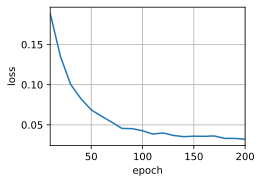

In [14]:
# 超参数设置
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]  # 层归一化的输入形状，对应 d_model

# 准备训练数据
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
# 这句从数据集中读取英文-法文翻译数据（英法平行语料），并返回：
#     train_iter: 可迭代的训练数据
#     src_vocab: 源语言词表（英文）
#     tgt_vocab: 目标语言词表（法文）

# 构建 Transformer 编码器和解码器
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
# 这部分构建了两个网络：
# TransformerEncoder: 输入为源语言序列（英语）
# TransformerDecoder: 输入为目标语言序列（法语）
# 二者都使用相同的结构参数（维度、层数等），但词表大小不同。

# 组装为 Encoder-Decoder 模型
net = d2l.EncoderDecoder(encoder, decoder)
# 这是整个 Transformer 模型的封装，符合之前章节中统一的 EncoderDecoder 接口形式。

# 模型训练
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)
# 调用封装好的训练函数：
#     自动进行编码-解码、掩码、损失计算
#     支持梯度裁剪、GPU训练
#     自动打印 loss 和训练进度
# 运行后即可看到如下图所示的 loss 下降图像，说明模型在拟合翻译任务。

训练结束后，使用Transformer模型[**将一些英语句子翻译成法语**]，并且计算它们的BLEU分数。


In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
# zip(engs, fras) 会一对一配对，比如 ('go .', 'va !')，('i lost .', 'j'ai perdu .')。
# for 循环中每次取出一个英文和对应法文句子。
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    # 调用 预测函数 predict_seq2seq()，用训练好的 net 来翻译 eng 这句话，生成：
    # translation：预测出来的法语翻译句子（是一个词符列表或字符串）
    # dec_attention_weight_seq：每个解码步骤的注意力权重（可用于可视化分析）
    # True 表示使用贪心解码（逐个选概率最高的词）
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est venu .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


当进行最后一个英语到法语的句子翻译工作时，让我们[**可视化Transformer的注意力权重**]。编码器自注意力权重的形状为（编码器层数，注意力头数，`num_steps`或查询的数目，`num_steps`或“键－值”对的数目）。


In [16]:
# 对 Transformer 编码器（Encoder）中的注意力权重进行可视化分析
# 收集注意力权重并 reshape 成结构化维度

enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads, -1, num_steps))
# net.encoder.attention_weights：是一个 列表，里面收集了所有层的注意力权重（通常是在前向传播时通过 self.attention_weights.append(...) 存进去的）
# torch.cat(..., 0)：将每一层拼接成一个大的 Tensor（沿着第0维，即层的维度）
# .reshape(...)：重新整理形状为：
#     (num_layers,        # 编码器层数
#      num_heads,         # 多头注意力的头数
#      num_steps,         # 查询的位置（即输出token的位置）
#      num_steps)         # 键的位置（即输入token的位置）
# 即： 每一层、每一个头都会有一个 [查询位置 × 键位置] 的二维注意力矩阵。

# 确认注意力张量的形状
enc_attention_weights.shape
# 2 层 Transformer 编码器
# 每层 4 个注意力头（Multi-Head Attention）
# 输入长度是 10（即一个句子有 10 个 token）
# 所以每个注意力矩阵大小为 [10×10]

torch.Size([2, 4, 10, 10])

在编码器的自注意力中，查询和键都来自相同的输入序列。因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。接下来，将逐行呈现两层多头注意力的权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。


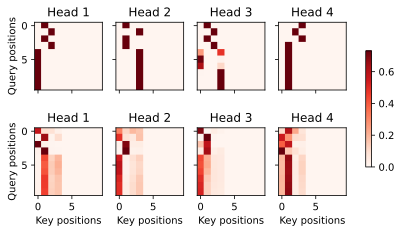

In [17]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))
# enc_attention_weights.cpu()：放到 CPU 上便于画图
# xlabel、ylabel：坐标轴标签
# titles=['Head 1', 'Head 2', ..., 'Head 4']：设置每个子图的标题
# figsize：画布大小

# 📊 可视化图像解释
# 热力图的含义如下：
#     横轴是 key 的位置（即输入序列中被“参考”的词）
#     纵轴是 query 的位置（当前正在生成的输出位置）
#     颜色深浅表示注意力权重的大小（越深越“关注”）
# 从图中可以看到：
#     不同的 Head 会关注不同的模式（有的偏好位置 0，有的偏好某些词）
#     注意力可以是稀疏的（只关注少数几个 key）

[**为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作。**]例如用零填充被掩蔽住的注意力权重。值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：即以*序列开始词元*（beginning-of-sequence,BOS）打头，再与后续输出的词元共同组成序列。


In [18]:
# Transformer 解码器（Decoder）中的自注意力机制的可视化尤其是：
#     解码器内部的“自注意力层”（Decoder Self-Attention）在预测输出序列时，每个时间步是如何关注先前已生成的词的。

# 📌 背景知识：为什么可视化解码器注意力比编码器麻烦？
#     编码器的注意力：输入序列是完整的，可以直接可视化 query→key 的注意分布。
#     解码器注意力：
#         有两种注意力：
#         ① 自注意力（self-attention）：只能看当前时间步之前的词（包括 BOS）；
#         ② 交叉注意力（cross-attention）：看编码器的输出。
#         由于解码器是逐词预测的，每次预测会加一个词到序列中，因此需要逐步构建注意力矩阵。

# ① 从 dec_attention_weight_seq 提取当前需要的头的数据
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
# 🚩 背景：
#     dec_attention_weight_seq 是一个三层嵌套的列表结构，形如：
#         [
#           [           # 每一步解码（step）
#             [         # 每一层解码器的输出（block）
#               [head_1, head_2, ..., head_h]   # 每个注意力头的注意力
#             ]
#           ],
#           ...
#         ]
#     这一行提取的是：每一步、每一层、每一个 head 的第一个头的数据，以方便后面转成张量。

# ② 转换成张量，填补缺失值为 0，并 reshape 成标准维度
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
# 把列表用 Pandas DataFrame 转成矩阵，缺失的地方补 0.0，再转成 tensor。
# fillna(0.0) 是为了填补当前生成词数还不够长的那些 attention 行（比如第 1 个词只能看 BOS）。

# ③ 调整维度
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
# 变成：
#     第 0 维：步数（翻译时每个 token 的生成）
#     第 1 维：2 代表两个注意力类型（self 和 cross attention）
#     第 2 维：解码器层数
#     第 3 维：head 数量
#     第 4 维：每个 head 是一个 query → key 的二维注意力分布（num_steps x num_steps）

# ④ 只取自注意力部分（索引为 0），并调整维度便于画图
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
# permute(1, 2, 3, 0, 4) 是为了把数据顺序调成：[self/cross->2, layer, head, query_step, key_step]
# 直接“拆包”出 decoder 的 self-attention 和 cross-attention 权重。

# 输出形状确认
dec_self_attention_weights.shape, dec_inter_attention_weights.shape
# 2 层解码器
# 每层 4 个头
# 生成了 6 个 token（包括 BOS）
# 每个 query 看 10 个 key（最多保留前 10 个位置）

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。


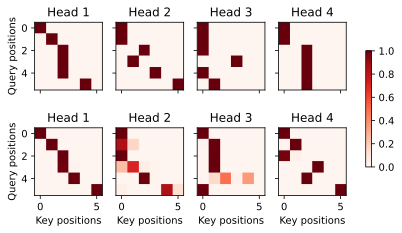

In [19]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

# translation.split() 是翻译出来的词序列长度，加 1 是为了包含 BOS
# 每幅图是：
#     y 轴：query 的位置（当前预测的位置）
#     x 轴：key 的位置（已经生成的 token）
# 每个头的热力图能看到解码器在预测第 n 个词时，关注了哪些先前已经生成的词。

与编码器的自注意力的情况类似，通过指定输入序列的有效长度，[**输出序列的查询不会与输入序列中填充位置的词元进行注意力计算**]。


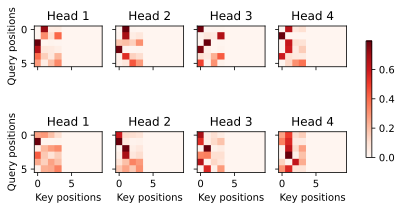

In [20]:
# Transformer 中解码器对编码器的注意力权重（cross-attention）进行可视化，是本节的最后一个可视化环节。

d2l.show_heatmaps(
    dec_inter_attention_weights,               # 解码器“交叉注意力”部分的权重张量
    xlabel='Key positions',                    # 横轴标签：键的位置
    ylabel='Query positions',                  # 纵轴标签：查询的位置
    titles=['Head %d' % i for i in range(1, 5)],# 每个子图的标题
    figsize=(7, 3.5)                            # 图像大小
)

# 🔥 图像解读：
#     每个小图是一个注意力头的热力图：
#         横坐标是键（key）的位置 → 对应英语输入的 token
#         纵坐标是查询（query）的位置 → 对应已经生成的法语 token
#         深红色表示注意力值高，表示“当前法语词关注了输入英语的某个位置”
#     比如：
#         某个位置在 Head 2 中注意力特别集中在输入序列的第 1 个 token，说明在翻译这个词时它“参考了”源语言中的第一个词。

# 🧠 背后原理：交叉注意力的作用
#     当解码器生成第 t 个目标词时，它会用这个词位置上的 query 去 attend 编码器输出的每个位置（key）
#     这样模型能“参考”源语言上下文，做出当前词的合理翻译

# 🔍 Transformer 交叉注意力热力图右边为空的原因解析

在使用 Transformer 可视化交叉注意力（Cross-Attention）权重时，我们经常会看到如下的热力图现象：

> **每个 Head 的热力图右侧一整块是空白的（白色），代表注意力值为零。**

---

## 📌 现象描述

在解码器的 cross-attention 层中，我们对每个 target token（例如法文中的每个词）计算它对所有 source token（例如英文输入词）的注意力权重。

热力图中的横轴（Key positions）：表示输入句子的 token（source）  
热力图中的纵轴（Query positions）：表示输出句子的 token（target）

---

## ❓ 为什么右侧为空？

这是因为在构造输入时，我们设定了 `num_steps` ——表示输入序列的最大长度。  
但真实的输入句子可能远远没有这么长，多余的位置就会被填充为 `<pad>` token（或 0）。

为了防止模型关注到这些“无意义”的位置，我们引入了 **valid lengths 掩码（mask）**：

- 在计算注意力分数时，填充的位置会被屏蔽掉（attention 分数设为 `-inf`）
- 经过 softmax 后，它们对应的 attention 权重为 **0**
- 因此在热力图中，这些位置就显示为空白（浅色/白色）

---

## 🧠 总结

热力图右边空白的本质原因是：

> 输入句子长度 < num_steps，模型对填充的 padding 部分 attention 值被强制设为 0，因此显示为白色。

这种做法是 **Transformer 架构处理变长输入的通用做法**，通过掩码机制保证模型不会“误关注”无效位置。

---

## ✅ 相关代码参考

```python
# 编码器输出的注意力权重形状为：
# [层数, 注意力头数, 查询序列长度, 键序列长度]
enc_attention_weights.shape
# 输出为: torch.Size([2, 4, 10, 10])，这里的10就是num_steps


尽管Transformer架构是为了*序列到序列*的学习而提出的，但正如本书后面将提及的那样，Transformer编码器或Transformer解码器通常被单独用于不同的深度学习任务中。

## 小结

* Transformer是编码器－解码器架构的一个实践，尽管在实际情况中编码器或解码器可以单独使用。
* 在Transformer中，多头自注意力用于表示输入序列和输出序列，不过解码器必须通过掩蔽机制来保留自回归属性。
* Transformer中的残差连接和层规范化是训练非常深度模型的重要工具。
* Transformer模型中基于位置的前馈网络使用同一个多层感知机，作用是对所有序列位置的表示进行转换。

## 练习

1. 在实验中训练更深的Transformer将如何影响训练速度和翻译效果？
1. 在Transformer中使用加性注意力取代缩放点积注意力是不是个好办法？为什么？
1. 对于语言模型，应该使用Transformer的编码器还是解码器，或者两者都用？如何设计？
1. 如果输入序列很长，Transformer会面临什么挑战？为什么？
1. 如何提高Transformer的计算速度和内存使用效率？提示：可以参考论文 :cite:`Tay.Dehghani.Bahri.ea.2020`。
1. 如果不使用卷积神经网络，如何设计基于Transformer模型的图像分类任务？提示：可以参考Vision Transformer :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`。


[Discussions](https://discuss.d2l.ai/t/5756)
